# Kaiser example

In this notebook we show how to implement a Kaiser power spectrum theory.
(which already exists in desilike.theories.galaxy_clustering).

In [1]:
import numpy as np
from scipy import special
from desilike.base import BaseCalculator
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate
from desilike.jax import interp1d
from desilike.jax import numpy as jnp
from desilike import plotting, utils


class KaiserTracerPowerSpectrumMultipoles(BaseCalculator):
    r"""
    Kaiser tracer power spectrum multipoles.
    For the matter (unbiased) power spectrum, set b1=1 and sn0=0.

    Parameters
    ----------
    k : array, default=None
        Theory wavenumbers where to evaluate multipoles.

    ells : tuple, default=(0, 2, 4)
        Multipoles to compute.

    mu : int, default=8
        Number of :math:`\mu`-bins to use (in :math:`[0, 1]`).

    template : BasePowerSpectrumTemplate
        Power spectrum template. Defaults to :class:`StandardPowerSpectrumTemplate`.

    shotnoise : float, default=1e4
        Shot noise (which is usually marginalized over).
    """
    # Here we define the parameters
    _params = {'b1': {'value': 1.5, 'prior': {'limits': [0., 10.], 'latex': 'b_1'}}, 'sn0': {'value': 0., 'prior': {'limits': [-1., 1.], 'latex': 's_0'}}}

    # Alternatively, if default parameters should depend on the input options to initialize, one can do:
    #@staticmethod
    #def _params(params, ells=(0, 2, 4)):
    #    # Update params
    #    params['b1'] = {'value': 1.5, 'prior': {'limits': [0., 10.], 'latex': 'b_1'}}
    #    params['sn0'] = {'value': 0., 'prior': {'limits': [-1., 1.], 'latex': 's_0'}}
    #    return params

    def initialize(self, k=None, ells=(0, 2, 4), mu=8, method='leggauss', template=None, shotnoise=1e4):
        if k is None: k = np.linspace(0.01, 0.2, 101)
        self.k = np.array(k, dtype='f8')
        self.ells = tuple(ells)
        self.nd = 1. / float(shotnoise)
        if template is None:
            template = DirectPowerSpectrumTemplate()
        self.template = template
        kin = np.geomspace(self.k[0] / 2, self.k[-1] * 2, 200)
        self.template.init.update(k=kin)
        self.mu, wmu = utils.weights_mu(mu, method=method)
        self.wmu = np.array([wmu * (2 * ell + 1) * special.legendre(ell)(self.mu) for ell in ells])

    def calculate(self, b1=1., sn0=0.):  # you can also get your parameter as kwargs, def calculate(self, **params):
        # Template includes AP effect routines
        jac, kap, muap = self.template.ap_k_mu(self.k, self.mu)
        # Template provides f, k, pk_dd (linear CDM + baryon power spectrum)
        f = self.template.f
        pkmu = jac * (b1 + f * muap**2)**2 * interp1d(jnp.log10(kap), jnp.log10(self.template.k), self.template.pk_dd, method='cubic') + sn0 / self.nd
        self.power = jnp.sum(pkmu * self.wmu[:, None, :], axis=-1)

    def get(self):
        return self.power

    # A plotting routine
    @plotting.plotter
    def plot(self, fig=None):
        """
        Plot power spectrum multipoles.

        Parameters
        ----------
        fig : matplotlib.figure.Figure, default=None
            Optionally, a figure with at least 1 axis.

        fn : str, Path, default=None
            Optionally, path where to save figure.
            If not provided, figure is not saved.

        kw_save : dict, default=None
            Optionally, arguments for :meth:`matplotlib.figure.Figure.savefig`.

        show : bool, default=False
            If ``True``, show figure.

        Returns
        -------
        fig : matplotlib.figure.Figure
        """
        from matplotlib import pyplot as plt
        if fig is None:
            fig, ax = plt.subplots()
        else:
            ax = fig.axes[0]
        for ill, ell in enumerate(self.ells):
            ax.plot(self.k, self.k * self.power[ill], color='C{:d}'.format(ill), linestyle='-', label=r'$\ell = {:d}$'.format(ell))
        ax.grid(True)
        ax.legend()
        ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        return fig

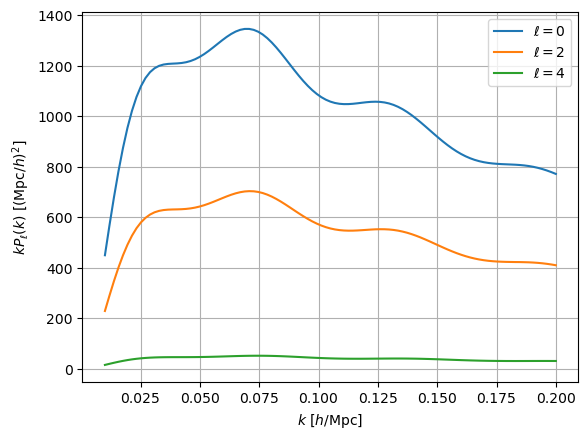

In [2]:
# Let's try it!

template = DirectPowerSpectrumTemplate(z=1.)
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
theory(h=0.7, b1=2.)
theory.plot(show=True);

Now we want to compare this theory (or any other) to an observed power spectrum, let's just write this down.

In [3]:
class TracerPowerSpectrumMultipolesObservable(BaseCalculator):

    # We just need to specify flatdata and flattheory

    def initialize(self, k=None, data=None, theory=None):
        if theory is None:
            theory = KaiserTracerPowerSpectrumMultipoles(k=k)
        if data is None:
            data = theory()
        self.data = data
        self.theory = theory
        self.flatdata = np.concatenate(self.data, axis=0)

    def calculate(self):
        self.flattheory = self.theory.power.ravel()

Then we have everything to write down our likelihood!

In [4]:
from desilike.likelihoods import ObservablesGaussianLikelihood

k = np.linspace(0.01, 0.2, 10)
theory.init.update(k=k)
data = theory()

observable = TracerPowerSpectrumMultipolesObservable(k=k, data=data, theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=np.eye(data.size))
print(likelihood(h=0.6))

-12425706.153281137


In [5]:
# For free we can solve for linear parameters, here sn0 (though we need to remove limits):
likelihood.all_params['sn0'].update(derived='.auto', prior=None)
print(likelihood.varied_params)
logp, derived = likelihood(logA=3., return_derived=True)
print(derived['sn0'])  # the best-fit sn0

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1'])
ParameterArray(sn0, None, 0.03579174081545622)
